<a href="https://colab.research.google.com/github/Surya-0804/Pytorch/blob/main/PytorchD3Text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from itertools import islice

In [ ]:
with open('/content/SampleTrain.txt', "r", encoding='utf-8') as f:
    text = f.read()

In [ ]:
len(text)

637775

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
tokens = word_tokenize(text)

In [ ]:
len(tokens)

129762

In [ ]:
vocab = sorted(set(tokens))

In [ ]:
len(vocab)

10712

In [ ]:
vocab = ["<PAD>", "<UNK>"] + vocab

In [ ]:
len(vocab)

10714

In [ ]:
vocab[:10]

['<PAD>', '<UNK>', '!', '#', '$', '%', '(', ')', '*', ',']

In [ ]:
context_size = 5
import random

In [ ]:
start = random.randint(0, len(tokens)-context_size)

In [ ]:
tokens[start:start+context_size]

['and', 'health', '.', 'I', 'had']

In [ ]:
tokens[start + context_size]

'desired'

In [ ]:
# Assuming "tokens" is your tokenized text
token_to_idx = {token: idx for idx, token in enumerate(vocab)}

# Now you can convert your tokens to indices
tokens_idx = [token_to_idx[token] for token in tokens]

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torch

class TextNgramDataset(Dataset):
  def __init__(self, data, n):
    self.data = data
    self.n = n

  def __len__(self):
    return len(self.data) - self.n

  def __getitem__(self, index):
    return (self.data[index: index+self.n], self.data[self.n + index])

CONTEXT_SIZE = 5  # this is your n-gram size

dataset = TextNgramDataset(tokens_idx, CONTEXT_SIZE)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Define batch size
batch_size = 32

def collate_fn(batch):
    sequences = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Convert the lists to tensors
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)

    return sequences, targets

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [ ]:
x, y = next(iter(train_dataloader))

In [ ]:
x.shape

torch.Size([32, 5])

In [ ]:
y.shape

torch.Size([32])

In [ ]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

class NGramLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_size=32):
        super(NGramLanguageModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim) # B,C,V => B,C,D
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size) #CxD -> 128
        self.linear2 = nn.Linear(hidden_size, vocab_size) # 128 -> V
        self.lnorm = nn.LayerNorm(hidden_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1)) #B, C*D
        out = F.relu(self.lnorm(self.linear1(embeds)))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [ ]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 20

model = NGramLanguageModel(VOCAB_SIZE, EMBEDDING_DIM, CONTEXT_SIZE)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Epoch: 0, Training Loss: 20391.329701423645, Test Loss: 4898.631054878235
Epoch: 1, Training Loss: 18092.97697329521, Test Loss: 4833.29771566391
Epoch: 2, Training Loss: 16849.887517929077, Test Loss: 4979.082851648331
Epoch: 3, Training Loss: 15899.128511428833, Test Loss: 5246.529784440994
Epoch: 4, Training Loss: 15144.812627077103, Test Loss: 5486.367367744446
Epoch: 5, Training Loss: 14555.390193462372, Test Loss: 5841.455601453781
Epoch: 6, Training Loss: 14100.266463279724, Test Loss: 6058.9039397239685
Epoch: 7, Training Loss: 13736.070514917374, Test Loss: 6385.922229766846
Epoch: 8, Training Loss: 13435.316470861435, Test Loss: 6662.723572254181
Epoch: 9, Training Loss: 13193.619974374771, Test Loss: 6654.81173992157
Epoch: 10, Training Loss: 13009.02062010765, Test Loss: 6799.211852550507
Epoch: 11, Training Loss: 12818.081438064575, Test Loss: 7171.329952716827
Epoch: 12, Training Loss: 12670.701811552048, Test Loss: 7271.298700809479
Epoch: 13, Training Loss: 12547.558323

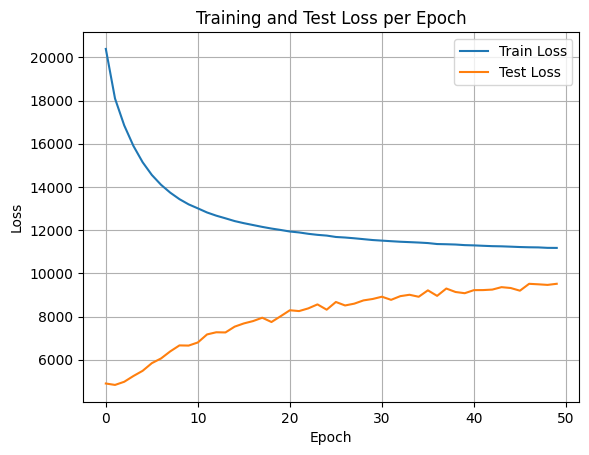

In [ ]:
import numpy as np

num_epochs = 50

# initialize the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # set the model to training mode
    total_train_loss = 0
    for context, target in train_dataloader:

        # Preparing the inputs and targets
        context_idxs = context.to(device)
        target = target.to(device)

        # Resetting the gradients
        model.zero_grad()

        # Forward pass
        log_probs = model(context_idxs)

        # Calculating loss
        loss = criterion(log_probs, target)

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Update total_loss
        total_train_loss += loss.item()

    train_losses.append(total_train_loss)

    # Test phase
    model.eval()  # set the model to eval mode
    total_test_loss = 0
    with torch.no_grad():
        for context, target in test_dataloader:
            context_idxs = context.to(device)
            target = target.to(device)

            # Forward pass
            log_probs = model(context_idxs)

            # Calculating loss
            loss = criterion(log_probs, target)

            # Update total_loss
            total_test_loss += loss.item()

    test_losses.append(total_test_loss)

    print(f"Epoch: {epoch}, Training Loss: {total_train_loss}, Test Loss: {total_test_loss}")

# Plotting the train and test loss per epoch
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# Assuming "tokens" is your tokenized text
idx_to_token = {idx: token for idx, token in enumerate(vocab)}
k = 5
def generate_text(model, start_text, generate_length=100):
    words = word_tokenize(start_text)
    model.eval()  # put the model in evaluation mode

    for i in range(generate_length):
        # Create a tensor for the current sequence of words (removing the first word if the length is over the context size)
        input_sequence = torch.tensor([token_to_idx[word] for word in words[-CONTEXT_SIZE:]], dtype=torch.long).unsqueeze(0).to(device)

        # Predict the next word using the current sequence, and get the last word of the output
        with torch.no_grad():
            #prediction = model(input_sequence).argmax(dim=1).item()
            probabilities = torch.nn.functional.softmax(model(input_sequence), dim=1)
            top_probs, top_indices = probabilities.topk(k)

            # Make sure they're 1-D lists
            top_probs = top_probs.squeeze()
            top_indices = top_indices.squeeze()

            # Choose one of the top k predicted words randomly as per their probabilities
            choice = random.choices(top_indices.tolist(), weights=top_probs.tolist(), k=1)[0]
            next_word = idx_to_token[choice]
            #next_word = idx_to_token[prediction]

        # Add the predicted word to the sequence
        words.append(next_word)
    return ' '.join(words)

start_text = "Today is a beautiful day"
print(generate_text(model, start_text))

NameError: name 'UNK_TOKEN' is not defined

In [ ]:
import nltk

# Tokenize your text into sentences
sentences = nltk.tokenize.sent_tokenize(text)
# Tokenize each sentence into words and convert to indexes.
# We assume that the `token_to_idx` dict maps each token to its corresponding index
indexed_sentences = []
for sentence in sentences:
    tokens = nltk.tokenize.word_tokenize(sentence)
    indexed_tokens = [token_to_idx.get(token, token_to_idx['<UNK>']) for token in tokens] # use the index of '<UNK>' for unknown tokens
    indexed_sentences.append(indexed_tokens)

In [ ]:
len(indexed_sentences)

In [ ]:
len(sentences)

In [ ]:
sentences[100]

In [ ]:
indexed_sentences[100]

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import torch
import random

class TextSequenceDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx][:-1]), torch.tensor(self.data[idx][1:])

def collate_fn(batch):
    inputs = [item[0] for item in batch]
    targets                                                     = [item[1] for item in batch]

    # Pad sequences in the same batch, pad_value defaults to 0
    # However, this assumes that your tokenization process turns the padding element (usually "<pad>") into 0.
    inputs = pad_sequence(inputs, batch_first=True, padding_value=token_to_idx["<PAD>"])
    targets = pad_sequence(targets, batch_first=True, padding_value=token_to_idx["<PAD>"])

    return inputs, targets

# Assume `sentences` is a list of lists, where each inner list contains the indexes (tokens) of a sentence
dataset = TextSequenceDataset(indexed_sentences)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:
x, y = next(iter(test_dataloader))

In [ ]:
x.shape

In [ ]:
x[0]

In [ ]:
y.shape

In [ ]:
y[0]

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        print(x.shape)
        self.lstm.flatten_parameters()
        out, (hidden, cell) = self.lstm(x)
        print(out.shape, hidden.shape, cell.shape)
        out = self.dropout(out)
        print(out.shape)
        out = self.fc(out)
        print(out.shape)
        return out

In [ ]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
CONTEXT_SIZE = 5  # this is your n-gram size
model = LSTMModel(VOCAB_SIZE+2, EMBEDDING_DIM, 50, 2)

In [ ]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
min_val_loss = float('inf')
patience = 10  # How many epochs with no improvement to validation loss to wait
epochs_no_improve = 0


num_epochs = 500
train_losses = []
test_losses = []

def compute_loss(outputs, targets, pad_token_id):
    criterion = nn.CrossEntropyLoss(reduction='none')
    outputs = outputs.contiguous().view(-1, outputs.shape[-1]) # size becomes [32*39, 4721]
    targets = targets.view(-1) # size becomes [32*39]

    losses = criterion(outputs, targets)

    mask = (targets != pad_token_id).float()  # mask size: (batch_size, seq_len)

    losses = losses * mask  # Apply the mask to the loss

    loss = losses.sum() / mask.sum()  # Calculate mean loss over non-padded tokens

    return loss


for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        # Compute the loss
        loss = compute_loss(outputs, targets, token_to_idx["<PAD>"])
        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss/len(train_dataloader))

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = compute_loss(outputs, targets, VOCAB_SIZE+1)
            test_loss += loss.item()
    val_loss = test_loss/len(test_dataloader)
    test_losses.append(val_loss)
    print(f"Epoch: {epoch}, Training Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
          print('Early stopping!')
          break




In [ ]:
idx_to_token = {idx: token for idx, token in enumerate(vocab)}
import numpy as np
def generate_text(model, seed, max_length=100):
    tokens = [token_to_idx[x] for x in nltk.tokenize.word_tokenize(seed)]
    model.eval()  # switch the model to evaluation mode
    seed = torch.tensor(tokens).unsqueeze(0)  # add batch dimension
    generated = tokens

    with torch.no_grad():  # so we don't do backpropagation during the generation phase
        for _ in range(max_length):
            output = model(seed.to(device))
            print(output.shape)
            #print(output.shape)
            next_word_probability = nn.functional.softmax(output[0][-1], dim=0).cpu().numpy()  # use softmax to convert the output to probability distrubtion
            #print("prob", next_word_probability.shape)
            next_word = np.random.choice(range(len(next_word_probability)), p=next_word_probability)
            generated += [next_word]
            seed = torch.cat((seed, torch.tensor([[next_word]])), 1)
    print(generated)
    return " ".join([idx_to_token[x] for x in generated])


In [ ]:
generate_text(model, "Today is", max_length=1)